In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
sns.set(rc = {'figure.figsize':(10, 6)})
pd.set_option("precision", 3)

In [2]:
folder = "/home/jarobyte/scratch/guemes/icdar/fr/baseline/experiments/"

In [3]:
files = os.listdir(folder)
len(files)

37

In [4]:
logs = pd.concat([pd.read_csv(folder + f) 
                       for f in tqdm(os.listdir(folder))])\
.assign(dropout = lambda df: df.dropout.round(2))
print(logs.shape)
logs.head()

  0%|          | 0/37 [00:00<?, ?it/s]

(442, 21)


,epoch,train_loss,train_error_rate,dev_loss,dev_error_rate,training_minutes,learning_rate,weight_decay,model,max_sequence_length,...,feedforward_dimension,encoder_layers,decoder_layers,attention_heads,activation,dropout,parameters,encoder_tokens,decoder_tokens,experiment_id
0,1,2.722,74.446,2.723,79.146,8.101,1.000e-04,0.01,Transformer,110,...,512,3,3,8,relu,0.0,1477826,194,194,22722342_10
1,2,2.604,73.192,2.683,79.935,16.224,1.000e-04,0.01,Transformer,110,...,512,3,3,8,relu,0.0,1477826,194,194,22722342_10
2,3,2.563,72.201,2.621,77.968,24.370,1.000e-04,0.01,Transformer,110,...,512,3,3,8,relu,0.0,1477826,194,194,22722342_10
3,4,2.487,70.203,2.579,76.465,32.504,1.000e-04,0.01,Transformer,110,...,512,3,3,8,relu,0.0,1477826,194,194,22722342_10
4,5,2.450,69.196,2.567,76.039,40.636,1.000e-04,0.01,Transformer,110,...,512,3,3,8,relu,0.0,1477826,194,194,22722342_10


In [5]:
experiments = logs\
.assign(fit = lambda df: df.apply(lambda r: {k:r[k] for k in ["train_loss", 
                                                              "dev_loss", 
                                                              "epoch"]}, 
                                  axis = 1))\
.groupby("experiment_id")\
.agg({"fit":(lambda x: min(x, key = lambda y: y["dev_loss"])),
      "parameters":max, 
      "dropout":max,
      "weight_decay":max,
      "embedding_dimension":max,
      "encoder_layers":max,
      "training_minutes":max})\
.assign(parameters = lambda df: df.parameters / 10**6, 
        train_loss = lambda df: df.fit.map(lambda x: x["train_loss"]),
        dev_loss = lambda df: df.fit.map(lambda x: x["dev_loss"]),
        epoch = lambda df: df.fit.map(lambda x: x["epoch"]))\
.drop(columns = "fit")
experiments.head(10)

,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
experiment_id,,,,,,,,,
22694232_1,1.478,0.1,1.000e-02,128,3,112.867,2.423,2.548,12
22694232_10,1.015,0.1,1.000e-03,128,2,71.005,0.413,0.461,12
22694232_11,1.015,0.4,1.000e-03,128,2,71.389,0.600,0.645,12
22694232_12,1.478,0.2,1.000e-04,128,3,101.180,0.183,0.262,12
22694232_2,1.015,0.2,1.000e-02,128,2,72.071,2.436,2.547,10
22694232_3,1.478,0.5,1.000e-04,128,3,112.512,0.288,0.318,10
22694232_4,1.015,0.2,1.000e-02,128,2,70.698,2.371,2.467,11
22694232_5,1.015,0.5,1.000e-03,128,2,75.956,1.037,0.883,12
22694232_6,1.015,0.2,1.000e-03,128,2,70.627,0.467,0.515,12


# evaluation

In [6]:
evaluation_folder = "/home/jarobyte/scratch/guemes/icdar/fr/baseline/evaluation/"

In [7]:
evaluation_files = os.listdir(evaluation_folder)
len(evaluation_files)

37

In [8]:
evaluation = pd.concat([pd.read_csv(evaluation_folder + f) 
                       for f in tqdm(os.listdir(evaluation_folder))])
print(evaluation.shape)
evaluation.head()

  0%|          | 0/37 [00:00<?, ?it/s]

(370, 9)


,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting
0,22717012_8,-76.334,disjoint,greedy,100,2.449,5.531,9.752,NaN
1,22717012_8,-166.460,disjoint,greedy,50,1.187,5.531,14.737,NaN
2,22717012_8,-25.367,disjoint,beam,100,3.852,5.531,6.933,NaN
3,22717012_8,-661.308,disjoint,beam,50,3.167,5.531,42.104,NaN
4,22717012_8,-13.650,sliding,greedy,50,12.205,5.531,6.285,uniform


In [9]:
results = evaluation.merge(experiments, right_index = True, left_on = "experiment_id")\
.sort_values("improvement", ascending = False)
results.head(10)

,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
5,22717012_12,-3.402,sliding,greedy,50,11.446,5.531,5.719,triangle,1.015,0.0,0.000e+00,128,2,66.326,0.176,0.289,4
6,22717012_12,-3.402,sliding,greedy,50,11.382,5.531,5.719,bell,1.015,0.0,0.000e+00,128,2,66.326,0.176,0.289,4
4,22717012_12,-4.288,sliding,greedy,50,11.302,5.531,5.768,uniform,1.015,0.0,0.000e+00,128,2,66.326,0.176,0.289,4
9,22694232_3,-4.357,sliding,beam,50,147.402,5.531,5.772,bell,1.478,0.5,1.000e-04,128,3,112.512,0.288,0.318,10
8,22694232_3,-4.357,sliding,beam,50,150.359,5.531,5.772,triangle,1.478,0.5,1.000e-04,128,3,112.512,0.288,0.318,10
6,22694232_3,-4.357,sliding,greedy,50,15.843,5.531,5.772,bell,1.478,0.5,1.000e-04,128,3,112.512,0.288,0.318,10
5,22694232_3,-4.357,sliding,greedy,50,15.736,5.531,5.772,triangle,1.478,0.5,1.000e-04,128,3,112.512,0.288,0.318,10
7,22694232_3,-4.913,sliding,beam,50,148.577,5.531,5.802,uniform,1.478,0.5,1.000e-04,128,3,112.512,0.288,0.318,10
4,22694232_3,-4.913,sliding,greedy,50,16.291,5.531,5.802,uniform,1.478,0.5,1.000e-04,128,3,112.512,0.288,0.318,10
5,22694232_9,-6.436,sliding,greedy,50,16.388,5.531,5.887,triangle,1.478,0.2,1.000e-04,128,3,102.392,0.184,0.265,12


In [10]:
results.sort_values("train_loss")

,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
8,22722342_1,-794.926,sliding,beam,50,178.636,5.531,49.494,triangle,1.478,0.0,1.000e-04,128,3,100.375,0.147,0.303,10
7,22722342_1,-763.683,sliding,beam,50,179.019,5.531,47.766,uniform,1.478,0.0,1.000e-04,128,3,100.375,0.147,0.303,10
2,22722342_1,-80.815,disjoint,beam,100,5.624,5.531,10.000,NaN,1.478,0.0,1.000e-04,128,3,100.375,0.147,0.303,10
9,22722342_1,-810.593,sliding,beam,50,178.361,5.531,50.361,bell,1.478,0.0,1.000e-04,128,3,100.375,0.147,0.303,10
0,22722342_1,-79.699,disjoint,greedy,100,3.703,5.531,9.938,NaN,1.478,0.0,1.000e-04,128,3,100.375,0.147,0.303,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,test,-1313.940,disjoint,greedy,10,0.460,5.531,78.198,NaN,1.478,0.1,1.000e-03,128,3,0.089,3.660,3.852,10
2,test,-1300.408,disjoint,beam,10,3.102,5.531,77.450,NaN,1.478,0.1,1.000e-03,128,3,0.089,3.660,3.852,10
7,test,-1327.743,sliding,beam,5,13.673,5.531,78.962,uniform,1.478,0.1,1.000e-03,128,3,0.089,3.660,3.852,10
5,test,-1354.354,sliding,greedy,5,2.298,5.531,80.434,triangle,1.478,0.1,1.000e-03,128,3,0.089,3.660,3.852,10


<AxesSubplot:>

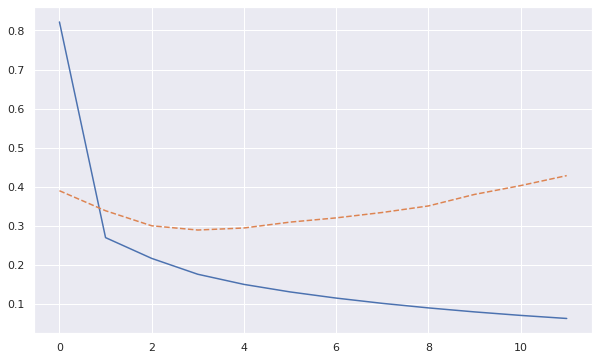

In [11]:
logs.query("experiment_id == '22717012_12'").train_loss.plot()
logs.query("experiment_id == '22717012_12'").dev_loss.plot(ls = "--")

In [12]:
results.query("experiment_id == '22717012_12'")\
[["experiment_id", "window", "window_size", "decoding", "weighting", "improvement"]]\
.sort_values(["window", "window_size", "decoding", "weighting"])\
.pivot(index = "experiment_id", 
       values = "improvement", 
       columns = ["window", "window_size", "decoding", "weighting"])

window        disjoint                        sliding                          \
window_size        50              100            50                            
decoding          beam  greedy    beam greedy    beam                  greedy   
weighting          NaN     NaN     NaN    NaN    bell triangle uniform   bell   
experiment_id                                                                   
22717012_12    -70.938 -55.953 -80.742 -77.79  -9.706   -9.865 -11.374 -3.402   

window                          
window_size                     
decoding                        
weighting     triangle uniform  
experiment_id                   
22717012_12     -3.402  -4.288